# Momentum Strategy

## Disadvantages-
1. It doesn't take into account the noise or special events. It has a tendency to smooth out prior events.
2. The transaction fees can be potentially high owing to the number of orders.

## Examples-
1. Moving Average Crossover
2. Dual moving average Crossover
3. Turtle Trading

# Dual moving average crossover

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt

C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [164]:
start_date='2016-01-01'
end_date='2018-01-01'
goog_data=data.DataReader("HINDALCO.NS",'yahoo',start_date,end_date)
goog_data['GOOG_Returns']=np.log(goog_data['Adj Close']/goog_data['Adj Close'].shift(1))

1. Short_mavg=Short term moving average values
2. Long_mavg= Long term moving average values
3. signal=True if the short_mavg is higher than the long_mavg
4. orders= 1 for long and -1 for short

In [165]:
def double_moving_average(df,short_window,long_window):
    signals=pd.DataFrame(index=df.index)
    signals["price"]=goog_data["Adj Close"]
    signals["short_mavg"]=df["Adj Close"].rolling(window=short_window,min_periods=1,center=False).mean()
    signals["long_mavg"]=df["Adj Close"].rolling(window=long_window,min_periods=1,center=False).mean()
    signals["signal"]=0
    signals["signal"][long_window:]=np.where(signals["short_mavg"][long_window:]>signals["long_mavg"][long_window:],1,0)
    signals["orders"]=signals["signal"].diff()
    return signals

In [166]:
ts=double_moving_average(goog_data,short_window=20,long_window=100)

C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0.5, 1.0, 'Double Moving Average Trading Strategy')

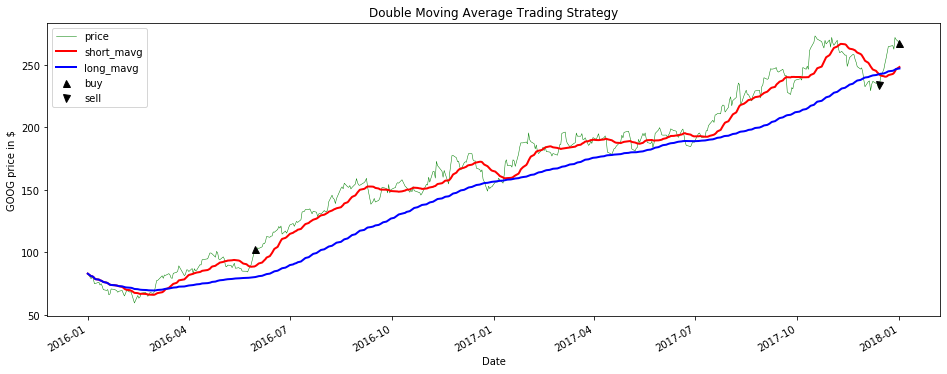

In [167]:
fig=plt.figure(figsize=(16,6))
ax1=fig.add_subplot(111,ylabel="GOOG price in $")
ts["price"].plot(ax=ax1,color="g",lw=0.5)
ts["short_mavg"].plot(ax=ax1,color="r",lw=2,legend=True)
ts["long_mavg"].plot(ax=ax1,color="b",lw=2,legend=True)
ax1.plot(ts.loc[ts.orders==1].index,goog_data["Adj Close"][ts.orders==1],"^",markersize=7,color="k",label="buy")
ax1.plot(ts.loc[ts.orders==-1].index,goog_data["Adj Close"][ts.orders==-1],"v",markersize=7,color="k",label="sell")
plt.legend()
plt.title("Double Moving Average Trading Strategy")

# Backtesting

In [168]:
# Declare the initial capital

initial_capital=float(300.0)
# Create a dataframe for positions and portfolio

positions=pd.DataFrame(index=ts.index).fillna(0.0)
portfolio=pd.DataFrame(index=ts.index).fillna(0.0)

# Store the GOOG positions in the portfolio

positions["GOOG"]=ts["signal"]
portfolio["positions"]=(positions.multiply(ts["price"],axis=0))#It accounts the positions at the end of day.

# Calculate the non-invested money(cash)

portfolio["cash"]=initial_capital-(positions.diff().multiply(ts.price,axis=0)).cumsum()#It contains the cashout at the end of day when the stock was sold
portfolio["total"]=portfolio["cash"]+portfolio["positions"]

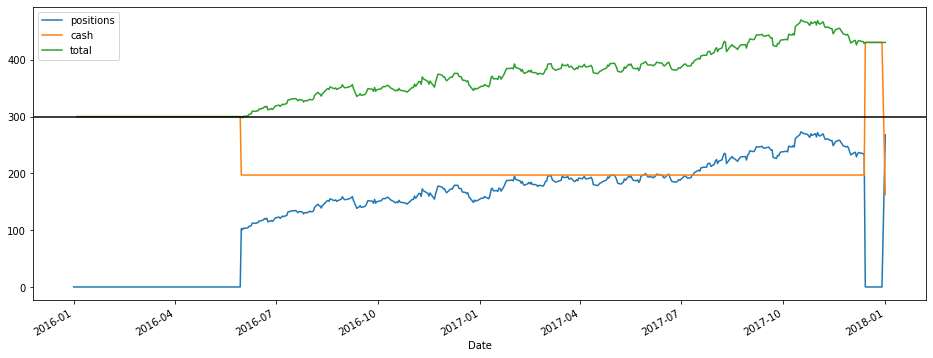

In [169]:
portfolio.plot(figsize=(16,6))
plt.axhline(y=initial_capital,color="k")

In [170]:
# Return at the end of the period
portfolio["total"].pct_change().dropna()

Date
2016-01-05    0.0
2016-01-06    0.0
2016-01-07    0.0
2016-01-08    0.0
2016-01-11    0.0
             ... 
2017-12-26    0.0
2017-12-27    0.0
2017-12-28    0.0
2017-12-29    0.0
2018-01-01    0.0
Name: total, Length: 493, dtype: float64

In [171]:
#CAGR
((np.prod((1+portfolio["total"].pct_change().dropna())))**(252/493)-1)*100

20.305438762593674

# Naive Trading Strategy

In [52]:
def naive_momentum_trading(df,nb_conseq_days_long,nb_conseq_days_short):
    signals=pd.DataFrame(index=df.index)
    signals["price"]=df["Adj Close"]
    signals["orders"]=0
    signals["signal"]=0
    cons_day=0
    prior_price=0
    init=True
    for k in range(1,len(df)):
        prior_price=df["Adj Close"][k-1]
        price=df["Adj Close"][k]
        if price>prior_price:
            if cons_day<0:
                cons_day=0
            cons_day=cons_day+1
        elif price<prior_price:
            if cons_day>0:
                cons_day=0
            cons_day=cons_day-1
        if cons_day==nb_conseq_days_long:
            signals["orders"][k]=1
        elif cons_day==-nb_conseq_days_short:
            signals["orders"][k]=-1
        if cons_day>=nb_conseq_days_long:
            signals["signal"][k]=1
        elif cons_day<=-nb_conseq_days_short:
            signals["signal"][k]=0
    return signals

In [69]:
ts=naive_momentum_trading(goog_data,nb_conseq_days_long=5,nb_conseq_days_short=7)

C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Chaitanya\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Turtle Trading Strategy')

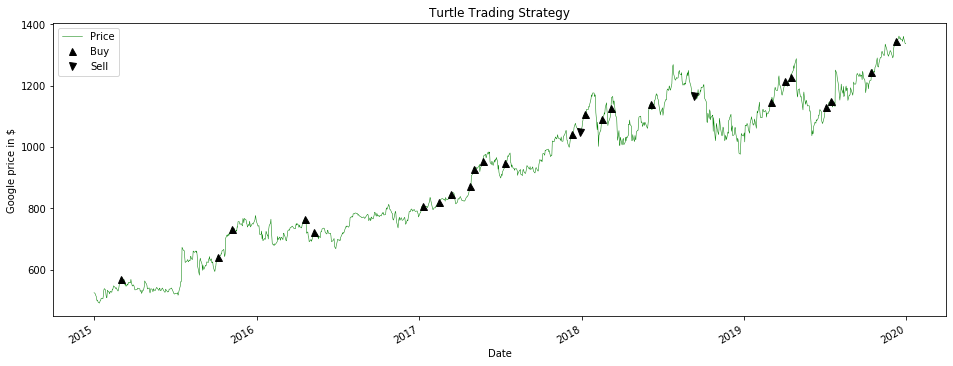

In [70]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ax1.plot(ts.loc[ts.orders== 1.0].index,goog_data["Adj Close"][ts.orders == 1],'^', markersize=7, color='k')
ax1.plot(ts.loc[ts.orders== -1.0].index,goog_data["Adj Close"][ts.orders == -1],'v', markersize=7, color='k')
plt.legend(["Price","Buy","Sell"])
plt.title("Turtle Trading Strategy")


# Turtle Strategy

In [14]:
def turtle_trading(df,window_size):
    signals=pd.DataFrame(index=df.index)
    signals["orders"]=0
#     window_size-days high
    signals["high"]=df["Adj Close"].shift(1).rolling(window=window_size).max()
#     window_size_days low
    signals["low"]=df["Adj Close"].shift(1).rolling(window=window_size).min()
#     window_size-days mean
    signals["avg"]=df["Adj Close"].shift(1).rolling(window=window_size).mean()
    signals["long_entry"]=df["Adj Close"]>signals.high
    signals["short_entry"]=df["Adj Close"]<signals.low
    signals["long_exit"]=df["Adj Close"]<signals.avg
    signals["short_exit"]=df["Adj Close"]>signals.avg
    init=True
    position=0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position=1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position=-1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0
    return signals

In [15]:
ts=turtle_trading(goog_data,50)

In [18]:
ts

,orders,high,low,avg,long_entry,short_entry,long_exit,short_exit
Date,,,,,,,,
2014-12-31,0,NaN,NaN,NaN,False,False,False,False
2015-01-02,0,NaN,NaN,NaN,False,False,False,False
2015-01-05,0,NaN,NaN,NaN,False,False,False,False
2015-01-06,0,NaN,NaN,NaN,False,False,False,False
2015-01-07,0,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...
2019-12-24,0,1361.170044,1217.140015,1301.307202,False,False,False,True
2019-12-26,0,1361.170044,1242.800049,1303.835603,False,False,False,True
2019-12-27,0,1361.170044,1242.800049,1306.183403,False,False,False,True


In [192]:
nifty=data.DataReader("^NSEI",'yahoo',start_date,end_date)
nifty['nifty_Returns']=np.log(nifty['Adj Close']/nifty['Adj Close'].shift(1))

In [199]:
((np.prod(1+nifty["nifty_Returns"].dropna()))**(252/492)-1)*100

15.790043244890306

In [200]:
# Beat the benchmark by
20.305438762593674-15.790043244890306

4.515395517703368